In [24]:
!ls

ls size-stats/
ls: cannot access 'size-stats/': No such file or directory


: 2

# Characterising STRs based on length and sequence

In [ ]:
!bcftools --version

bcftools 1.19-23-g7bd34556
Using htslib 1.19-8-g5627ef61
Copyright (C) 2024 Genome Research Ltd.
License Expat: The MIT/Expat license
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.


In [ ]:
!bcftools query -f"%CHROM\t%POS\t%INFO/PERIOD\t%INFO/RU\n" output/ensembletr_output/ensembletr.vcf.gz > motif_info.tab
!cat motif_info.tab

chr1	77887913	3	AAG
chr4	3074877	3	AGC
chr4	3074940	3	CCG
chr11	57528484	2	AT
chr14	64253561	2	AC
chr17	51831668	3	AGC
chr21	43776443	12	CCCCGCCCCGCG


In [28]:
# import libraries
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn as sns


### Distribution of the fraction of non-reference alleles in individuals by super population

In [3]:
populations=("africa" "europe" "east_asia" "south_asia" "america")

for population in "${populations[@]}"; do

    bcftools view -S str_resources/"${population}"_sample_ids.txt output/ensembletr_output/ensembletr.vcf.gz \
        | python3 qc.py "${population}"

done

defaultdict(<class 'int'>, {'HG03054': 3, 'NA19023': 2, 'NA19152': 2, 'NA19700': 4, 'HG02646': 1, 'HG03060': 3, 'HG03385': 2, 'HG03472': 1, 'NA20278': 1, 'HG03458': 1, 'HG02465': 1, 'NA18510': 1})
defaultdict(<class 'int'>, {'HG00120': 3, 'HG00185': 1, 'HG00188': 1, 'HG00231': 1, 'HG00242': 2, 'HG00342': 1, 'HG00343': 2, 'HG00358': 2, 'HG01673': 1, 'HG01679': 3, 'HG01685': 2, 'NA10847': 1, 'NA12046': 2, 'NA20518': 2, 'NA20542': 1, 'NA20802': 3, 'HG00313': 1, 'NA11830': 1})
defaultdict(<class 'int'>, {'HG00613': 3, 'HG00437': 2, 'HG00457': 1, 'HG00671': 1, 'HG01807': 1, 'HG01863': 2, 'HG02061': 1, 'HG02139': 2, 'HG02181': 2, 'HG02379': 1, 'NA18559': 2, 'NA18639': 1, 'NA18954': 1, 'NA18974': 2, 'NA19064': 1, 'NA19066': 2, 'NA19079': 1})
defaultdict(<class 'int'>, {'HG03848': 3, 'HG02649': 3, 'HG03491': 3, 'HG03595': 1, 'HG03684': 1, 'HG03733': 2, 'HG03780': 2, 'HG03787': 1, 'HG03792': 2, 'HG03830': 2, 'HG03868': 1, 'HG03885': 2, 'HG03953': 3, 'HG03965': 1, 'HG04003': 2, 'HG04093': 2, 'HG

In [15]:
super_populations = ["africa", "europe", "east_asia", "south_asia", "america"]

######## Reading variation files excluding homopolymers ########
df = pd.DataFrame(columns = super_populations)


for pop in super_populations:

    var_data_whole = pd.DataFrame(columns = ['Sample', 'ref', 'non_ref'])

    for chromosome in range(1,23):

        var_data = pd.read_csv(f"{pop}_no_homo.txt", delimiter="\t", header=None)
        var_data.columns = ['Sample', 'ref_chr', 'non_ref_chr']
        if len(var_data_whole) == 0:
            var_data_whole = var_data.copy()
            var_data_whole.columns = ['Sample', 'ref', 'non_ref']

        else:

            var_data_whole = pd.merge(var_data_whole,var_data, on = "Sample")
            var_data_whole['ref'] = var_data_whole['ref'] + var_data_whole['ref_chr']
            var_data_whole['non_ref'] = var_data_whole['non_ref'] + var_data_whole['non_ref_chr']
            var_data_whole = var_data_whole.drop(columns = ['ref_chr', 'non_ref_chr'])
        df[pop] = var_data_whole['non_ref'] / (var_data_whole['ref'] + var_data_whole['non_ref'])


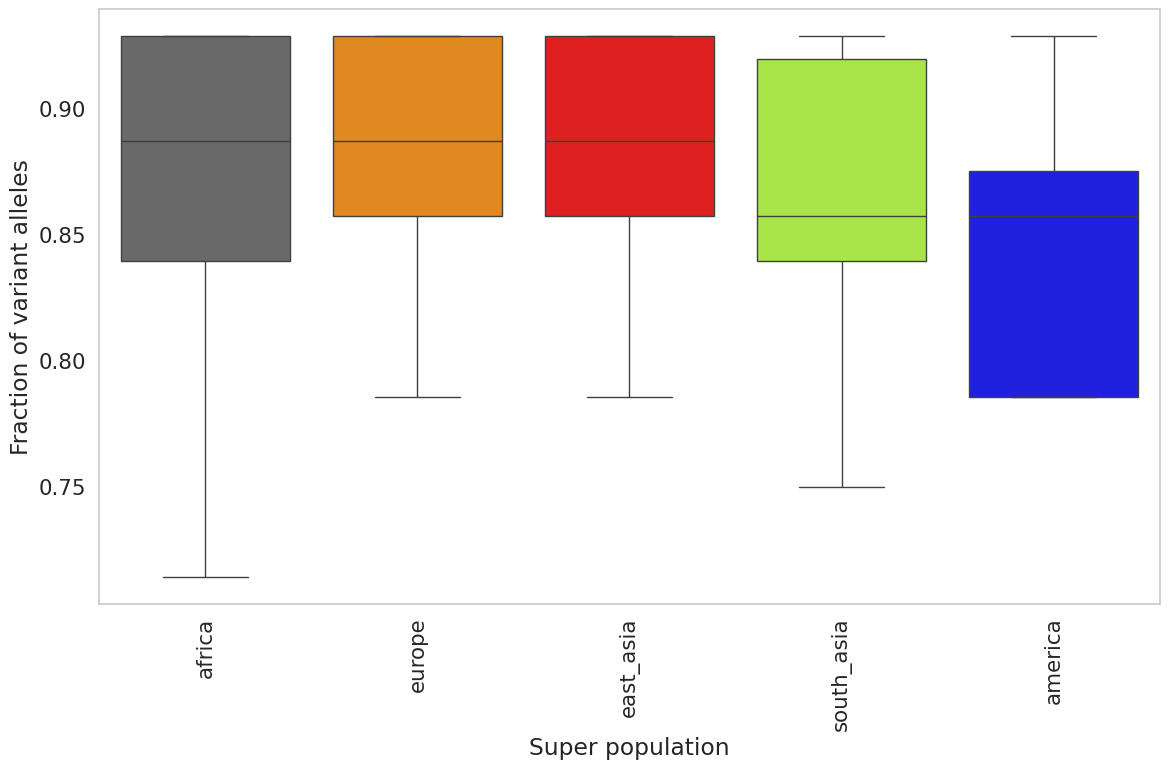

In [16]:
colors = ["dimgrey", "darkorange", "red", "greenyellow", "blue", "purple"]

color_dict = dict(zip(super_populations, colors))
sns.set(rc={'figure.figsize':(12,8)},font_scale = 1.4)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(data=df, palette=color_dict)
ax.set(xlabel='Super population', ylabel='Fraction of variant alleles')

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("variants_without_homopolymer.pdf", dpi=1200)

### Population-specific allele distributions

In [17]:
%%bash 

# get genotype statistics using statSTR

populations=("africa" "europe" "east_asia" "south_asia" "america")

for population in "${populations[@]}"; do

    statSTR \
        --vcf output/ensembletr_output/ensembletr.vcf.gz \
        --vcftype hipstr \
        --thresh --afreq --use-length \
        --out downstream/"${population}"_stats \
        --samples str_resources/"${population}"_sample_ids.txt

done

# Get list of STR, period, diff, AF
# python get_diff_af.py output/ensembletr_output/ensembletr.vcf.gz > downstream/diff_afreqs.tab


# For each sample, count how many alleles match ref, ref+1, ref-1, etc.
# Do separately for homopolymers and non-homopolymers
python summarize_allele_sizes.py output/ensembletr_output/ensembletr.vcf.gz > downstream/asize_summary.tab


Done

Done

Done

Done

Done


/home/ibra/protocol/genotyping_repeats_tutorial/summarize_allele_sizes.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["Superpopulation"] = samples["Superpopulation"].apply(GetPopOrder)
Reading records
HG02105
HG02330
HG03885
HG01097
NA19746
HG01054
HG03385
NA19734
HG01628
HG02181
HG01365
HG00457
HG01841
HG03733
HG02006
NA19670
NA21093
HG03848
HG04003
HG01063
HG00437
NA18559
NA20802
HG03060
HG01976
HG01383
HG03830
HG01468
NA11830
HG01807
HG02804
NA19064
NA19700
HG00342
HG03024
NA18974
NA18510
HG02139
NA19079
NA20278
NA20542
HG01685
HG02061
HG00343
NA19107
HG00188
HG02465
HG03595
NA18639
NA19024
HG00231
HG00613
HG02861
HG03458
HG02649
HG01673
HG03054
HG03868
HG00671
HG00242
HG01679
HG03472
NA19066
HG00185
NA19752
NA18909
HG01863
HG012

In [1]:
####### Set up #########
def GetSuperpopColors(spop):
    if "Europe" in spop: return "blue"
    if "Africa" in spop: return "gold"
    if "America" in spop: return "red"
    if "East Asia" in spop: return "green"
    if "South Asia" in spop: return "purple"


/tmp/ipykernel_23302/3803074471.py:11: FutureWarning: The provided callable <function sum at 0x7f82e43bc720> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby(["spop","type"], as_index=False).agg(aggdict)
/tmp/ipykernel_23302/3803074471.py:11: FutureWarning: The provided callable <function sum at 0x7f82e43bc720> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby(["spop","type"], as_index=False).agg(aggdict)


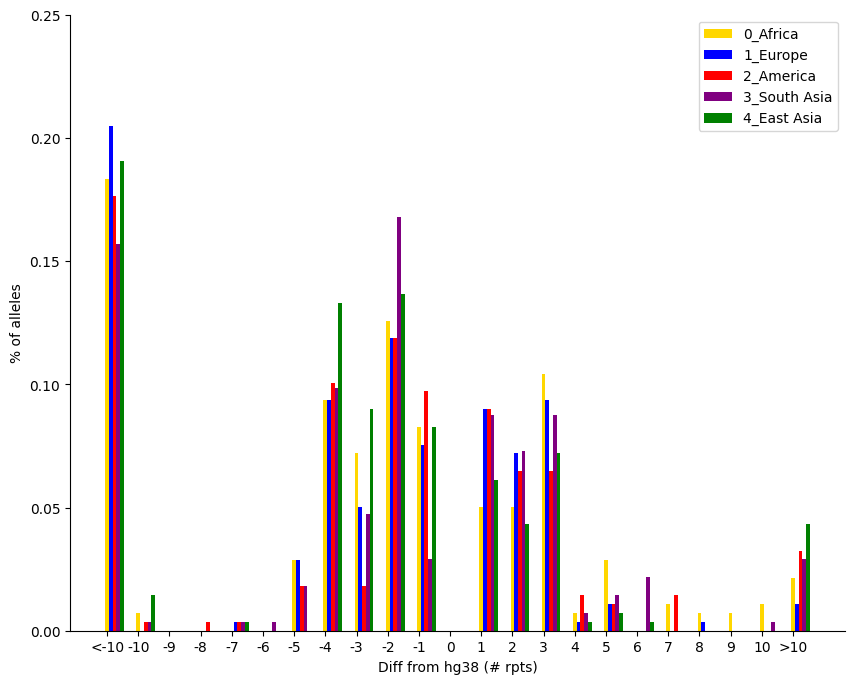

In [13]:
# Load data, sum across all chromosomes
# data gives counts of allele sizes in each sample,
# separately for homopolymers/non-homopolymers

sizecols = list(range(-11, 12))
data = pd.read_csv("downstream/asize_summary.tab", sep="\t", names=["sample","spop","pop","type"] + sizecols)

# Aggregate by summarizing across samples/chromosomes
aggdict = {}
for i in sizecols: aggdict[i] = np.sum
data = data.groupby(["spop","type"], as_index=False).agg(aggdict)

w = 0.12
vtype = "other"

byspop = data[data["type"]==vtype].copy()
byspop.index = byspop["spop"]
byspop = byspop.drop(columns = ["spop","type"])
byspop = byspop.div(byspop.sum(axis=1), axis=0)
byspop[0] = np.nan

fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111)
i = 0
for spop in sorted(list(byspop.index)):
    vals = byspop.loc[spop]
    color = GetSuperpopColors(spop)
    ax.bar([item+w*i for item in sizecols], vals, color=color, label=spop, width=w)
    i += 1
ax.legend(loc="upper right")
ax.set_xticks(sizecols)
ax.set_xticklabels(["<-10"]+list(range(-10, 11)) + [">10"])
ax.set_xlabel("Diff from hg38 (# rpts)")
ax.set_ylabel("% of alleles")
ax.set_ylim(bottom=0, top=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

figname = "DiffFromRef-Nonhomopolymer.pdf"

fig.savefig(os.path.join("downstream", figname))

### Allele distribution

In [30]:
%%bash
# CHROM="1"
# START=77887913

# CHROM="4"
# START=3074877

# CHROM="11"
# START=57528484

# CHROM="14"
# START=64253561

# CHROM="17"
# START=51831668

CHROM="21"
START=43776443

statSTR \
    --vcf output/ensembletr_output/ensembletr.vcf.gz \
    --vcftype hipstr \
    --afreq --use-length \
    --region chr${CHROM}:${START}-${START} \
    --out downstream/chr${CHROM}.${START}_stats \
    --samples str_resources/africa_sample_ids.txt,str_resources/america_sample_ids.txt,str_resources/europe_sample_ids.txt,str_resources/east_asia_sample_ids.txt,str_resources/south_asia_sample_ids.txt \
    --sample-prefixes africa,america,europe,east_asia,south_asia



Done


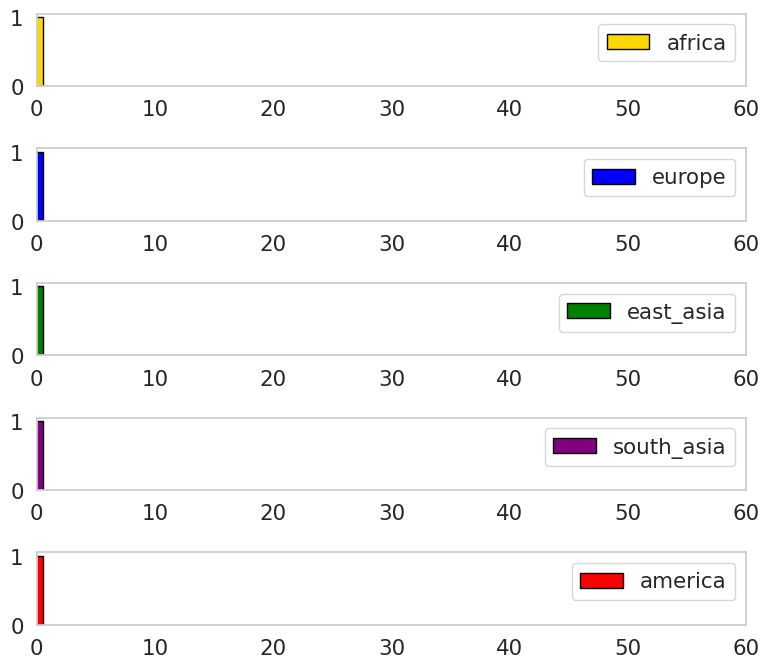

In [39]:
CHROM="1"
START=77887913

# CHROM="4"
# START=3074877

# CHROM="11"
# START=57528484

# CHROM="14"
# START=64253561

# CHROM="17"
# START=51831668

# CHROM="21"
# START=43776443


MAXVAL = 60 # change per locus

def GetRowColors(spop):
    if "europe" in spop: return "blue"
    if "africa" in spop: return "gold"
    if "america" in spop: return "red"
    if "east_asia" in spop: return "green"
    if "south_asia" in spop: return "purple"

data = pd.read_csv("downstream/chr%s.%s_stats.tab"%(CHROM, START), sep="\t")
if data.shape[0] != 1:
    assert("Need to find exactly one locus!")

fig = plt.figure()
fig.set_size_inches((8, 8))
popnum = 0
w = 0.15

for pop in ["africa", "europe", "east_asia", "south_asia", "america"]:
    ax = fig.add_subplot(6, 1, popnum+1)
    vals = data["afreq-%s"%pop].values[0]
    xvals = []
    yvals = []
    for ainfo in vals.split(","):
        allele, freq = ainfo.split(":")
        allele = int(float(allele))
        freq = float(freq)
        xvals.append(allele)
        yvals.append(freq)
    ax.bar(xvals, yvals, color=GetRowColors(pop), edgecolor="black", label=pop, width=1)
    ax.legend(loc="upper right")
    popnum += 1
    ax.set_xlim(left=0, right=MAXVAL)
    
#ax.legend(loc="upper right");
#ax.set_xlabel("Allele length")
#ax.set_ylabel("Frequency");

fig.savefig("%s_%s.commonexp.pdf"%(CHROM, START))
fig.tight_layout()

### Heterozygosity 

In [51]:
%%bash 
# Compute het, n_alleles for all and for each superpopulation

statSTR \
    --vcf output/ensembletr_output/ensembletr.vcf.gz \
    --vcftype hipstr \
    --het --nalleles --use-length \
    --samples str_resources/sample_ids.txt,str_resources/africa_sample_ids.txt,str_resources/america_sample_ids.txt,str_resources/europe_sample_ids.txt,str_resources/east_asia_sample_ids.txt,str_resources/south_asia_sample_ids.txt \
    --sample-prefixes all,africa,america,europe,east_asia,south_asia \
    --out downstream/het.stats

bcftools query -f"%CHROM\t%POS\t%INFO/PERIOD\n" output/ensembletr_output/ensembletr.vcf.gz > downstream/het.period.tab



Done


In [52]:
# reading in data
dfs = []

data = pd.read_csv("downstream/het.stats.tab", sep="\t")
perdata = pd.read_csv("downstream/het.period.tab", sep="\t", names=["chrom","start","period"])
data = pd.merge(data, perdata, on=["chrom","start"])
dfs.append(data)

data = pd.concat(dfs)
data_other = data[data["period"] != 1]
# data_hom = data[data["period"] == 1]

[0.14285714285714285, 0.0, 0.14285714285714285, 0.14285714285714285, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0]
[0.0, nan, 0.578, 0.557, nan, nan, 0.626, nan, nan, nan]
Het=0: 0.14285714285714285 TFs


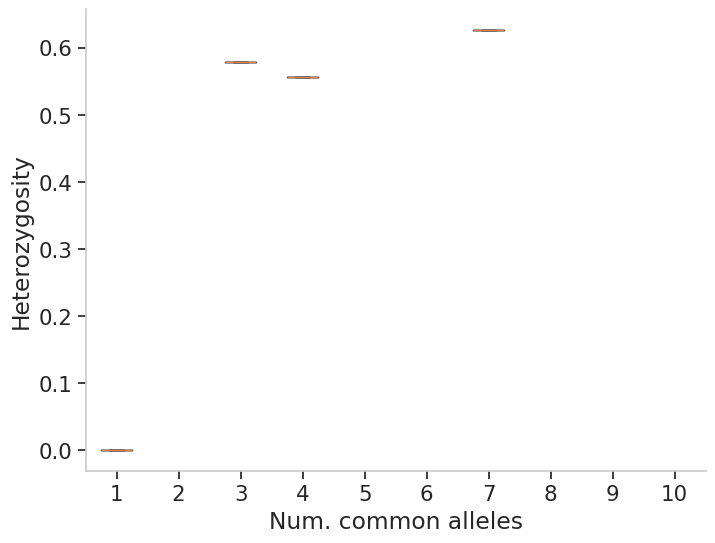

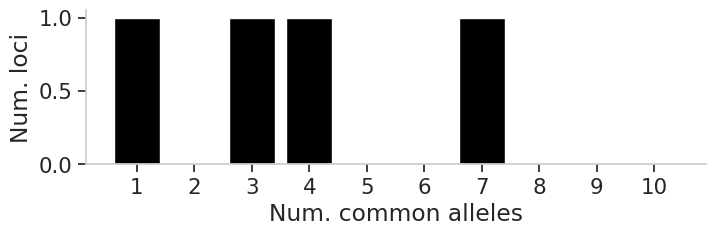

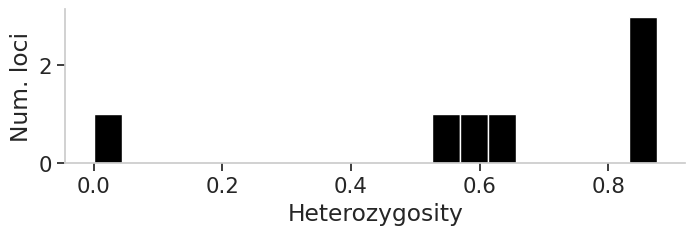

In [57]:
MAX_N = 10

for (prefix, df) in [("other",data_other)]:
    # Plot num alleles vs. het
    fig = plt.figure()
    fig.set_size_inches((8, 6))
    ax = fig.add_subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    boxdata = []
    for n in range(1, MAX_N+1):
        boxdata.append(list(df[df["nalleles-all"]==n]["het-all"]))
    ax.boxplot(boxdata, sym="");
    ax.set_xlabel("Num. common alleles")
    ax.set_ylabel("Heterozygosity");
    fig.savefig("HetVsNallele-Boxplot-%s.pdf"%prefix)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches((8, 2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.bar(range(1, MAX_N+1), [df[df["nalleles-all"]==n].shape[0] for n in range(1, MAX_N+1)], color="black");
    ax.set_xticks(range(1,MAX_N+1))
    ax.set_xticklabels(range(1,MAX_N+1));
    ax.set_xlabel("Num. common alleles")
    ax.set_ylabel("Num. loci");
    fig.savefig("HetVsNallele-NAlleleHist-%s.pdf"%prefix)

    # Print percentages to annotate and cite in the text
    print([df[df["nalleles-all"]==n].shape[0]/df.shape[0] for n in range(1, MAX_N+1)])
    print([np.mean(df[df["nalleles-all"]==n]["het-all"]) for n in range(1, MAX_N+1)])

    # How many have het nearly 0?
    x = (df[df["het-all"]<0.001].shape[0])/(df.shape[0])
    print("Het=0: %s TFs"%x)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches((8, 2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.hist(df["het-all"], color="black", bins=20)
    ax.set_xlabel("Heterozygosity")
    ax.set_ylabel("Num. loci");
    fig.savefig("HetVsNallele-HetHist-%s.pdf"%prefix)

africa america other r=1.00 p=2.3795777658734534e-06
africa europe other r=0.99 p=5.047471134645814e-05
africa east_asia other r=0.98 p=0.00017072906396857729
africa south_asia other r=0.98 p=5.759707888604863e-05
america europe other r=0.98 p=8.072535910497466e-05
america east_asia other r=0.97 p=0.0002022671465563751
america south_asia other r=0.98 p=0.00013520884841354861
europe east_asia other r=0.93 p=0.002119525082527777
europe south_asia other r=0.94 p=0.0013661558958585117
east_asia south_asia other r=0.98 p=0.00012164438970798129


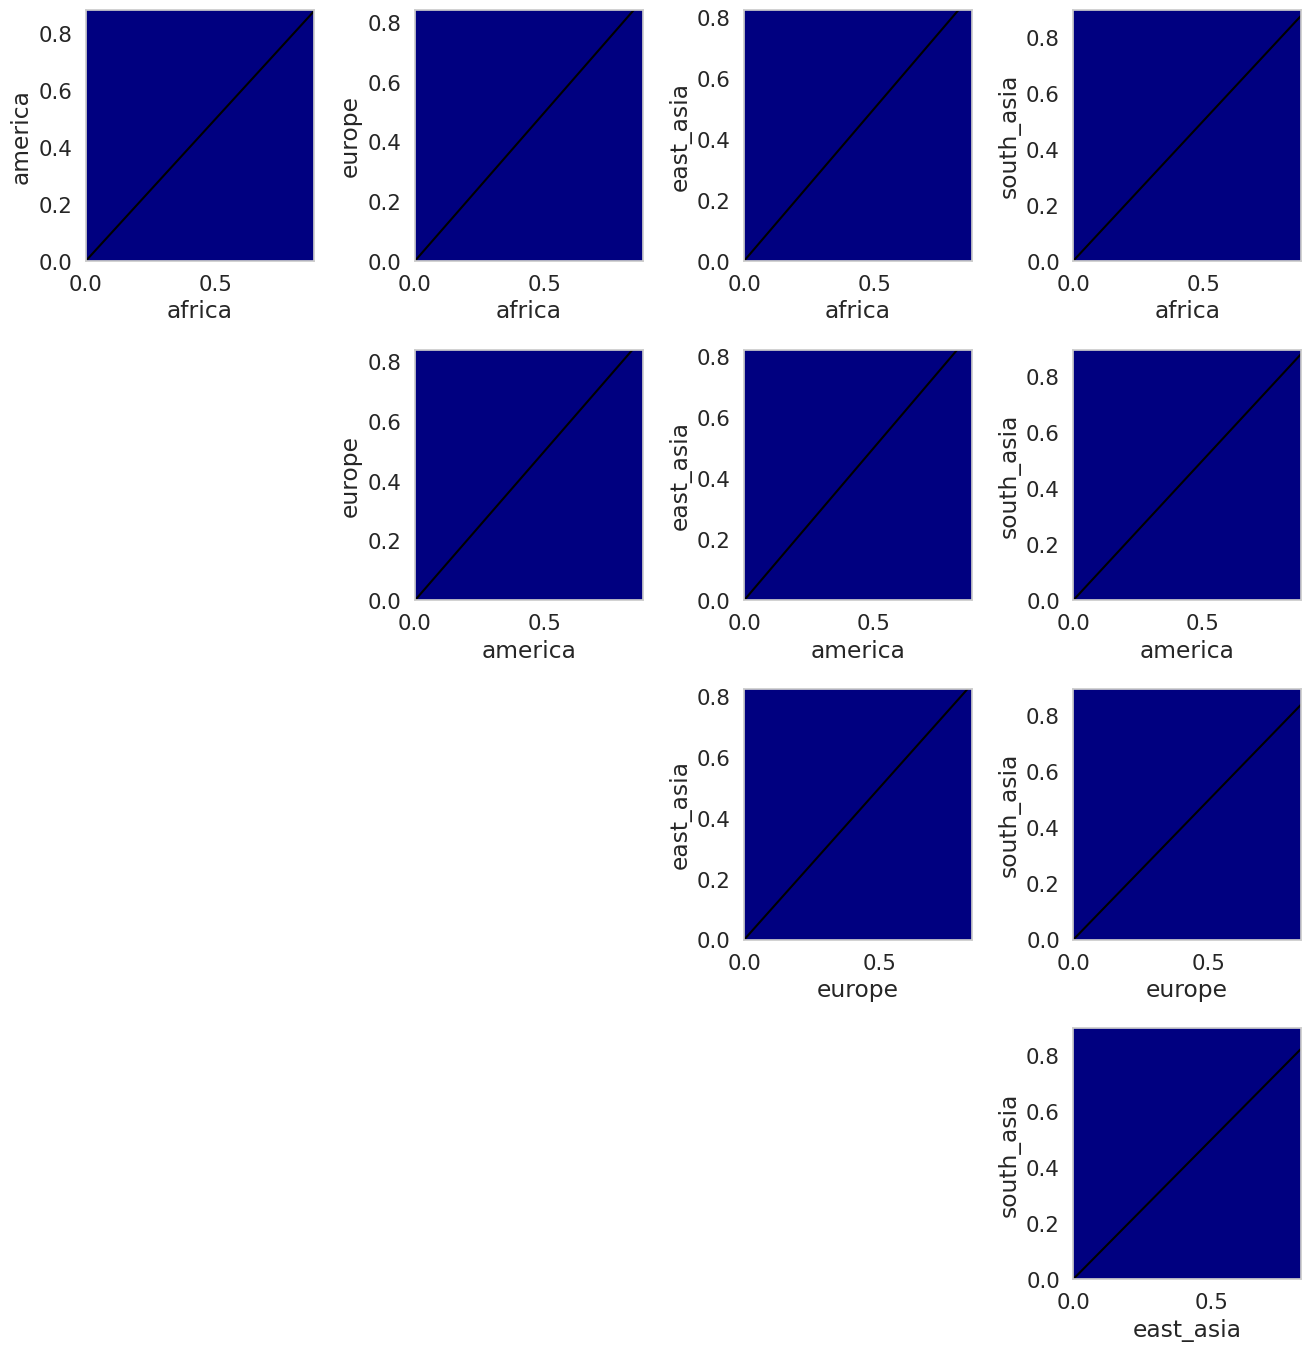

In [58]:
# pairwise comparisons of heterozygosity

spops = ["africa","america","europe","east_asia","south_asia"]
mycmap = plt.cm.jet

for (prefix, df) in [("other",data_other)]:
    fig = plt.figure()
    fig.set_size_inches((20, 20))
    pltnum = 1
    for i in range(len(spops)):
        for j in range(i, len(spops)):
            if i==j: continue
            ax = fig.add_subplot(6, 6, i*6+j)
            pop1 = spops[i]
            pop2 = spops[j]
            xx = df[~np.isnan(df["het-%s"%pop1]) & ~np.isnan(df["het-%s"%pop2])]
            
            r, p = scipy.stats.pearsonr(xx["het-%s"%pop1], xx["het-%s"%pop2])
            print("%s %s %s r=%.2f p=%s"%(pop1, pop2, prefix, r, p))
        
            ax.hist2d(xx["het-%s"%pop1], xx["het-%s"%pop2], bins=50, norm=LogNorm(), cmap=mycmap);
            ax.plot([0,1],[0,1], color="black")
            ax.set_xlabel(pop1)
            ax.set_ylabel(pop2)
    fig.tight_layout()